In [3]:
#add here the path to the module
import sys
sys.path.insert(1,'/scicore/home/nimwegen/witzg/MoMA_Python_Git/')
sys.path.insert(1, '/Users/guillaume/Desktop/PostdocBasel/MoMA_python_Git/')
print('test')

test


In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.path import Path
import scipy.ndimage as nd
from skimage.segmentation import active_contour
from skimage.color import label2rgb
import skimage.morphology as morpho
from skimage.measure import regionprops, label, find_contours

import image_import as ii
from MMdata import MMData 
import platesegmenter as ps

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
#define data folder

#folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170223/20170223_highmed_2'
folder = '/Volumes/MusiqueHD/201710126_lowerbound'

In [4]:
MMobj = MMData(folder = folder)

In [6]:
#create data object and define metadata
MMobj = MMData(folder = folder)
positions, well = ps.get_position_names(MMobj)
well_index = np.ravel([[x for x in range(well.shape[0]) if well[x] in y] for y in positions])
#num_planes = MMobj.get_number_planes()
z_step = MMobj.get_zstep()
#mid_plane = (np.max(num_planes)-1)/2

In [7]:
#this shows you the order of color acqusition
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [8]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [17]:
ps.get_position_names(MMobj)

(['B11-Site_0',
  'B11-Site_1',
  'B11-Site_2',
  'B11-Site_3',
  'B10-Site_0',
  'B10-Site_1',
  'B10-Site_2',
  'B10-Site_3',
  'B9-Site_0',
  'B9-Site_1',
  'B9-Site_2',
  'B9-Site_3',
  'B8-Site_0',
  'B8-Site_1',
  'B8-Site_2',
  'B8-Site_3',
  'B6-Site_0',
  'B6-Site_1',
  'B6-Site_2',
  'B6-Site_3',
  'B5-Site_0',
  'B5-Site_1',
  'B5-Site_2',
  'B5-Site_3',
  'B4-Site_0',
  'B4-Site_1',
  'B4-Site_2',
  'B4-Site_3',
  'B3-Site_0',
  'B3-Site_1',
  'B3-Site_2',
  'B3-Site_3',
  'B2-Site_0',
  'B2-Site_1',
  'B2-Site_2',
  'B2-Site_3',
  'C2-Site_0',
  'C2-Site_1',
  'C2-Site_2',
  'C2-Site_3',
  'C3-Site_0',
  'C3-Site_1',
  'C3-Site_2',
  'C3-Site_3',
  'C4-Site_0',
  'C4-Site_1',
  'C4-Site_2',
  'C4-Site_3',
  'C5-Site_0',
  'C5-Site_1',
  'C5-Site_2',
  'C5-Site_3',
  'C6-Site_0',
  'C6-Site_1',
  'C6-Site_2',
  'C6-Site_3',
  'C7-Site_0',
  'C7-Site_1',
  'C7-Site_2',
  'C7-Site_3',
  'C8-Site_0',
  'C8-Site_1',
  'C8-Site_2',
  'C8-Site_3',
  'C9-Site_0',
  'C9-Site_1',
  

In [9]:
#choose which positions should be used to create training dataset.
#Leave as chosen_pos = [] if you just want to analyze all images in the dataset.
chosen_pos = ['B8-Site_1','B8-Site_2']

In [10]:
#where should training data be saved
#path_to_save = '/scicore/home/nimwegen/witzg/PlateSegmenter_Python_Git/DeepPlate/correlation_weight_large/'
path_to_save = '/Users/guillaume/Desktop/PostdocBasel/PlateSegmenter_Python_Git/DeepPlate/Learn201710126/'
    
#Dimensions and size of training and test datasets
channels = 1
image_rows = 96
image_cols = 96
num_train = 50
num_test = 20

In [11]:
disk = morpho.disk(radius=4)

This is image #0: B8-Site_1


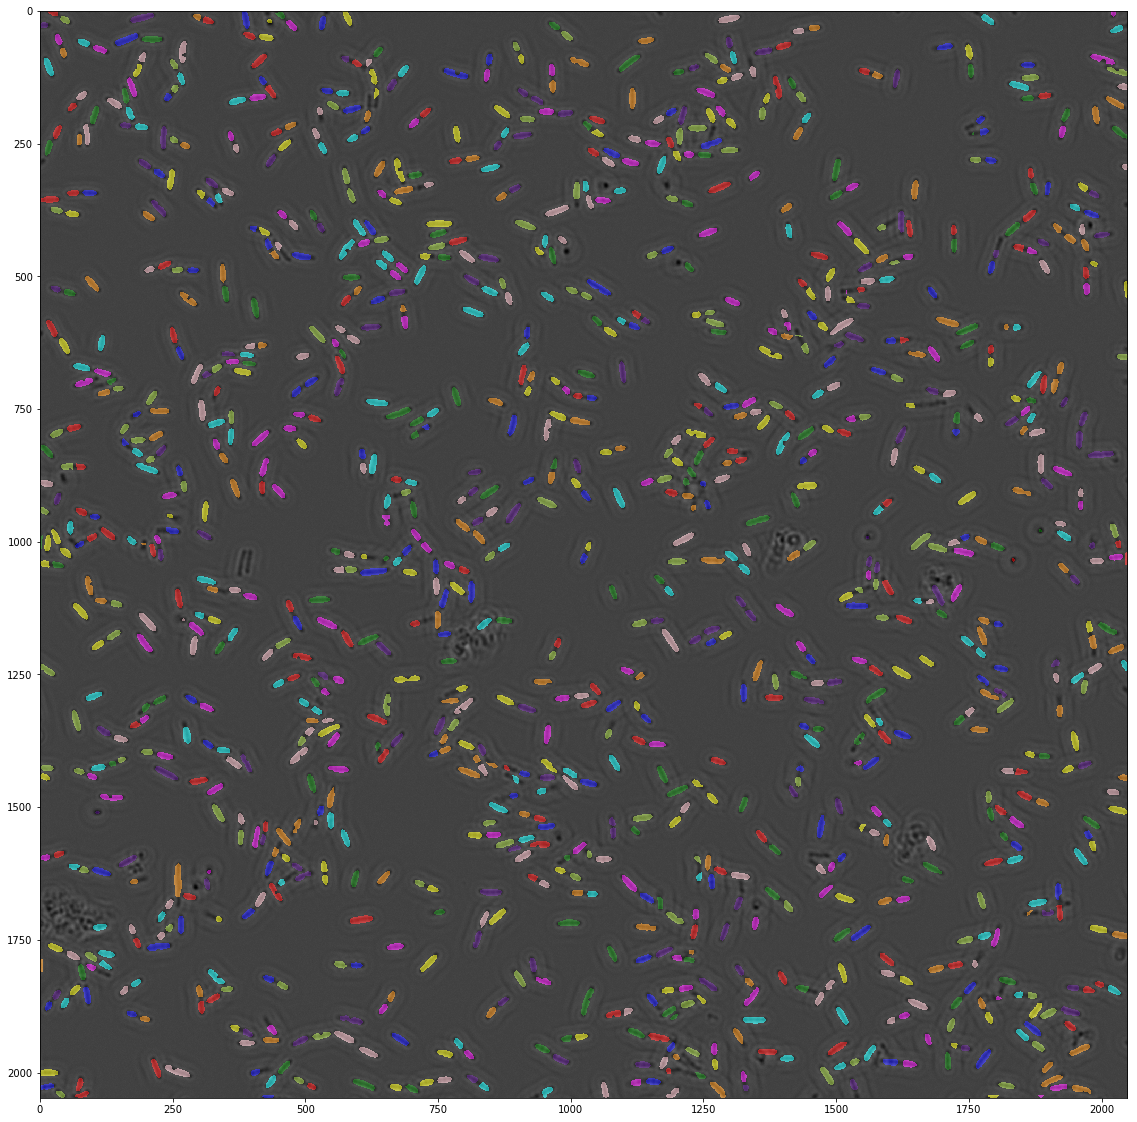

In [14]:
#Definition of structures containing training and test datasets
num_tot = num_train+num_test
imgs = np.ndarray((num_train, image_rows, image_cols,channels), dtype=np.float64)
imgs_mask = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_weight = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_weight[:]=1
imgs_test = np.ndarray((num_test, image_rows, image_cols,channels), dtype=np.float64)
imgs_id = np.ndarray((num_test, ), dtype=np.int32)

#Generate training/test dataset. Loads images sequentially, segments cells based on fluorescnce,
#saves a croped image around each cell as single training example. As long as the desired number of 
#training/test dataset is not reached, new images are loaded and analyzed.
counter = 0
poscount = 0
unfinished = False
disk = morpho.disk(radius=2)
if len(chosen_pos)==0:
    chosen_pos = positions
while counter<num_tot:
    if poscount>len(chosen_pos):
        print("you did not select enough positions to create the required training set")
        unfinished = True
        break
    print('This is image #'+str(poscount)+': '+chosen_pos[poscount])
    
    #define current position to analyze
    position = np.argwhere(np.array(positions)==chosen_pos[poscount])[0][0]
    poscount+=1
    
    #load fluorescence image and gaussian filter it
    imfluo = MMobj.get_stack(frame=0,channel=fluo_ch,position=position, compress = 1)[:,:,0]
    imfluo_gauss = nd.gaussian_filter(imfluo,3)
    
    #calculate image gradient. Any pixel with significant gradient is used to calculate an average cell fluorecence
    imgrad = np.gradient(imfluo_gauss)
    imgrad = np.sqrt(imgrad[0]**2+imgrad[1]**2)
    mean_fluo = np.mean(imfluo[imgrad>100])

    #load bf stack and calculated correlation image
    stack = MMobj.get_stack(frame=0,channel=bf_ch,position=position, compress = 1)    
    correlated_norm = ps.phase_corr_simple(stack,thickness=800,z_step=z_step)
    correlated_norm_gauss = nd.gaussian_filter(correlated_norm,3)
    
    #filter fluo image with cross-correlation steerable filters. 
    #This enhances both cell interior regions (negative) and regions where cells touch (positive)
    steer_all = np.zeros((imfluo.shape[0],imfluo.shape[1], 20))
    for i in range(20):
        steer_all[:,:,i] = ps.steerable2_crosscorr(imfluo_gauss, i*np.pi/20,1.5)
    fluo_steer = np.max(steer_all, axis = 2)
    
    #make maks for negative regions (cells). Exclude low intensity regions which are not cells
    fluo_steer_mask = np.zeros(fluo_steer.shape)
    fluo_steer_mask[fluo_steer<0] = 1
    fluo_steer_mask[imfluo_gauss<0.8*mean_fluo]=0
    fluo_mask_lab = label(fluo_steer_mask)

    #Analyze each mask region and keep reasonably shaped ones
    cell_info = regionprops(fluo_mask_lab)
    cell_info = [x for x in cell_info if (x.area>100)&(x.solidity>0.75)]
    newMask = np.zeros(fluo_mask_lab.shape)
    for i in range(len(cell_info)):
        newMask[fluo_mask_lab == cell_info[i].label]=1
    newMask_lab = label(newMask)
    
    cell_info = regionprops(newMask_lab)
    img_all = np.pad(fluo_steer,20,mode = 'constant')
    masktot = np.zeros(img_all.shape)
    for cellid in range(len(cell_info)):

        #cell mask clean-up and definition of cell contour
        imlab_temp = np.pad(cell_info[cellid].image,3,mode = 'constant',constant_values=0)
        imlab_temp = morpho.binary_closing(imlab_temp,selem=disk)
        #imlab_temp = np.pad(imlab_temp,3,mode = 'constant',constant_values=0)

        contours = find_contours(imlab_temp,0.5)
        init = contours[0]+17*np.ones(contours[0].shape)
        init = np.fliplr(init)
        init = np.concatenate([[init[x,:],(init[x,:]+init[x+1,:])/2] for x in range(init.shape[0]-1)])

        #image cropping and active contour smoothing
        img = img_all[cell_info[cellid].bbox[0]+20-20:cell_info[cellid].bbox[2]+20+20,
         cell_info[cellid].bbox[1]+20-20:cell_info[cellid].bbox[3]+20+20]

        snake = active_contour(img, init,alpha=0.01, beta=1.0, w_line=0, w_edge=1, gamma=0.1)

        #find pixels within boundary of new contour and create mask
        cg = np.mean(snake,axis = 0)
        snake = snake-np.repeat(np.array([cg]),snake.shape[0],axis =0)
        snake = 1*snake
        snake = snake+np.repeat(np.array([cg]),snake.shape[0],axis =0)

        x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0])) # make a canvas with coordinates
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x,y)).T 

        p = Path(snake) # make a polygon
        grid = p.contains_points(points)
        mask = grid.reshape(img.shape[0],img.shape[1])

        masktot[cell_info[cellid].bbox[0]+20-20:cell_info[cellid].bbox[2]+20+20,
         cell_info[cellid].bbox[1]+20-20:cell_info[cellid].bbox[3]+20+20] = masktot[cell_info[cellid].bbox[0]+20-20:cell_info[cellid].bbox[2]+20+20,
         cell_info[cellid].bbox[1]+20-20:cell_info[cellid].bbox[3]+20+20]+mask

    #create a mask for the cell boundary. This mask is used to define the weight-image that helps the 
    #deep learning network to learn those important regions
    masktot[masktot>0] = 1
    distance = nd.distance_transform_edt(masktot)
    distance[distance != 1] = 0
    distance = morpho.binary_dilation(distance)
    distance[masktot==1] = 0
    distance = distance*10+1

    distance = distance[20:-20,20:-20]
    masktot = masktot[20:-20,20:-20]

    #show segmentation result
    fig, ax = plt.subplots(figsize=(20,20))
    plt.imshow(1-correlated_norm,cmap='gray')
    #plt.imshow(label(masktot),alpha = 0.5, cmap = ListedColormap ( np.random.rand ( 256,3)))
    plt.imshow(label2rgb(label(masktot),bg_label=0),alpha = 0.5)
    plt.show()
    
    #crop all cell regions and store each of them as learning/test exmaple
    for s in cell_info:
        center = np.round(s.centroid).astype(int)
        if (center[0]>48)&(center[0]<2048-48-1)&(center[1]>48)&(center[1]<2048-48-1):
            #img = stack[center[0]-48:center[0]+48,center[1]-48:center[1]+48,:]
            img = correlated_norm_gauss[center[0]-48:center[0]+48,center[1]-48:center[1]+48]
            img_mask = 255*masktot[center[0]-48:center[0]+48,center[1]-48:center[1]+48]
            img_weight = distance[center[0]-48:center[0]+48,center[1]-48:center[1]+48]

            if counter<num_train:
                if channels==1:
                    imgs[counter] = img[..., np.newaxis]
                else:
                    imgs[counter] = img
                imgs_mask[counter] = img_mask
                imgs_weight[counter] = img_weight
            else:
                if channels==1:
                    imgs_test[counter-num_train] = img[..., np.newaxis]
                else:
                    imgs_test[counter-num_train] = img
                    
                imgs_id[counter-num_train] = counter-num_train
            counter+=1
            if counter ==num_tot:
                break
        if counter ==num_tot:
            break
    
#save all the data structures
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
np.save(path_to_save+'imgs_train.npy', imgs)
np.save(path_to_save+'imgs_mask_train.npy', imgs_mask.reshape((num_train,image_cols*image_rows)))
np.save(path_to_save+'imgs_weight_train.npy', imgs_weight.reshape((num_train,image_cols*image_rows)))
np.save(path_to_save+'imgs_test.npy', imgs_test)
np.save(path_to_save+'imgs_id_test.npy', imgs_id)

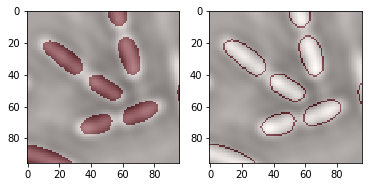

In [15]:
#check individul examples of training set
plt.subplot(1,2,1)
id = 30
plt.imshow(imgs[id,:,:,0],cmap = 'gray')
plt.imshow(np.reshape(imgs_mask[id,:],(96,96)),alpha = 0.5, cmap = 'Reds')
plt.subplot(1,2,2)
plt.imshow(imgs[id,:,:,0],cmap = 'gray')
plt.imshow(np.reshape(imgs_weight[id,:],(96,96)),alpha = 0.5, cmap = 'Reds')
plt.show()

In [16]:
len(cell_info)

1192